In [2]:
import pandas as pd

def read_json_in_chunks(file_path, chunk_size):
    # Abrimos el archivo en modo lectura por líneas
    with pd.read_json(file_path, lines=True, chunksize=chunk_size) as reader:
        # Iteramos sobre los chunks del archivo
        for chunk in reader:
            yield chunk  # Devolvemos el chunk actual

# Inicializamos variables para procesar todos los chunks
file_path = '../../Data/review-002.json'
chunk_size = 1000000  # Tamaño de cada chunk

# Iteramos sobre el archivo y procesamos cada chunk
for i, df_chunk in enumerate(read_json_in_chunks(file_path, chunk_size)):
    print(f"Procesando chunk {i + 1}")
    
    # Aquí puedes realizar operaciones con el chunk (df_chunk)
    # Por ejemplo, almacenar en una lista, concatenar con otro DataFrame, etc.
    # df_chunk -> contiene el DataFrame del chunk actual

    # Si deseas concatenar cada chunk a un DataFrame general:
    if i == 0:
        full_df = df_chunk  # Primer chunk
    else:
        full_df = pd.concat([full_df, df_chunk], ignore_index=True)

# Al final del bucle, 'full_df' contendrá todo el archivo.
print("Archivo completo procesado.")


Procesando chunk 1
Procesando chunk 2
Procesando chunk 3
Procesando chunk 4
Procesando chunk 5
Procesando chunk 6
Procesando chunk 7
Archivo completo procesado.


1. Análisis Exploratorio de Datos (EDA)

a. Tipos de Datos

In [3]:
print("Tipos de datos en full_df:")
print(full_df.dtypes)


Tipos de datos en full_df:
review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


b. Valores Faltantes y Nulos

In [4]:
# Verifica los valores faltantes en cada columna
print("Valores faltantes en full_df:")
print(full_df.isnull().sum())

# Verifica si hay valores nulos en cada columna
print("Número de valores nulos en cada columna:")
print(full_df.isna().sum())

Valores faltantes en full_df:
review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64
Número de valores nulos en cada columna:
review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64


c. Duplicados

In [5]:
# Verifica si hay filas duplicadas
print("Número de filas duplicadas:")
print(full_df.duplicated().sum())

Número de filas duplicadas:
0


d. Metadatos / Diccionario de datos:

In [6]:
# Muestra un resumen de las columnas
print("Resumen de columnas en full_df:")
print(full_df.describe(include='all'))

Resumen de columnas en full_df:
                     review_id                 user_id  \
count                  6990280                 6990280   
unique                 6990280                 1987929   
top     KU_O5udG6zpxOg-VcAEodg  _BcWyKQL16ndpBdggh2kNA   
freq                         1                    3048   
mean                       NaN                     NaN   
min                        NaN                     NaN   
25%                        NaN                     NaN   
50%                        NaN                     NaN   
75%                        NaN                     NaN   
max                        NaN                     NaN   
std                        NaN                     NaN   

                   business_id         stars        useful         funny  \
count                  6990280  6.990280e+06  6.990280e+06  6.990280e+06   
unique                  150346           NaN           NaN           NaN   
top     _ab50qdWOk0DdB6XOrBitw           Na

Cargamos el dataframe de 'business.pkl' para encontrar valores de Philadelphia

In [19]:
# Cargar el DataFrame
business_df = pd.read_pickle('../../Data/business.pkl')

In [12]:
# Verificar índices duplicados
duplicates = business_df.index.duplicated()
if duplicates.any():
    print(f"Hay {duplicates.sum()} índices duplicados.")
    # Eliminar índices duplicados
    business_df = business_df[~duplicates]

In [21]:
print(business_df['city'])

                 city city
0       Santa Barbara  NaN
1              Affton  NaN
2              Tucson  NaN
3        Philadelphia  NaN
4          Green Lane  NaN
...               ...  ...
150341       Edmonton  NaN
150342      Nashville  NaN
150343   Indianapolis  NaN
150344   Edwardsville  NaN
150345   Apollo beach  NaN

[150346 rows x 2 columns]


In [22]:
# Eliminar columnas duplicadas, conservando la primera instancia
business_df = business_df.loc[:, ~business_df.columns.duplicated()]

In [23]:
# Verificar las columnas restantes
print("Columnas en el DataFrame:\n", business_df.columns)

Columnas en el DataFrame:
 Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')


In [24]:
# Convertir la Columna 'city' a tipo string
business_df['city'] = business_df['city'].astype(str)

# Eliminar espacios en blanco
business_df['city'] = business_df['city'].str.strip()

# Filtrar los datos para Philadelphia
philadelphia_business_df = business_df[business_df['city'] == 'Philadelphia']

e. Distribucion de datos

count    14570.000000
mean        64.261702
std        165.296222
min          5.000000
25%          9.000000
50%         19.000000
75%         53.000000
max       5721.000000
Name: review_count, dtype: float64


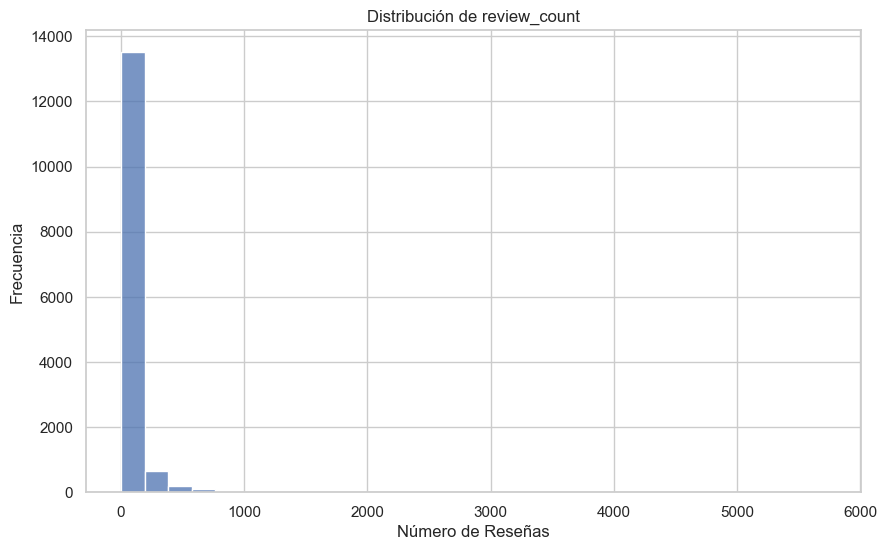

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir review_count a numérico usando .loc para evitar advertencias
philadelphia_business_df.loc[:, 'review_count'] = pd.to_numeric(philadelphia_business_df['review_count'], errors='coerce')

# Resumen de estadísticas descriptivas
stats = philadelphia_business_df['review_count'].describe()
print(stats)

# Histograma básico de review_count
plt.figure(figsize=(10, 6))
sns.histplot(philadelphia_business_df['review_count'].dropna(), bins=30, kde=False)
plt.title('Distribución de review_count')
plt.xlabel('Número de Reseñas')
plt.ylabel('Frecuencia')
plt.show()

f. Deteccion de Outliers

In [30]:
# Función para detectar outliers usando IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Detectar outliers en cada columna numérica
outliers_dict = {}
for col in numeric_cols:
    # Convertir a numérico utilizando .loc para evitar SettingWithCopyWarning
    philadelphia_business_df.loc[:, col] = pd.to_numeric(philadelphia_business_df[col], errors='coerce')
    outliers = detect_outliers_iqr(philadelphia_business_df, col)
    if not outliers.empty:
        outliers_dict[col] = outliers.shape[0]
        print(f'Número de outliers en {col}:', outliers.shape[0])

print("Outliers detectados en columnas numéricas:\n", outliers_dict)

Número de outliers en review_count: 1824
Outliers detectados en columnas numéricas:
 {'review_count': 1824}
